# Offline exact probabilities
This notebook is to calculate the exact probabilities. 

In [5]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation

Traceback (most recent call last):
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/matplotlib/mathtext.py", line 2517, in parse
    result = self._expression.parseString(s)
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 1125, in parseString
    raise exc
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 1115, in parseString
    loc, tokens = self._parse( instring, 0 )
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 1046, in _parseCache
    value = self._parseNoCache( instring, loc, doActions, callPreParse )
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 989, in _parseNoCache
    loc,tokens = self.parseImpl( instring, preloc, doActions )
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 2624, in parseImpl
    return self.expr._parse( instring,

In [6]:
T_total = 1.0
T1 = 0.100
T2 = 0.200
dt = 0.001
tau_z = 0.100

def produce_signal(T_total, T1, T2, dt, tau_z):
    n_time_total = int(T_total / dt)
    time = np.linspace(0, T_total, num=n_time_total)
    s = np.zeros(n_time_total)
    T_training = T2 - T1
    max_argument = T_training / tau_z
    maximum_value = 1 - np.exp(-max_argument)
    
    for index, t in enumerate(time):
        if t < T1:
            s[index] = 0
        if t >= T1 and t < T2:
            argument = (t - T1) / tau_z
            s[index] = 1 - np.exp(-argument)
        if t >= T2:
            coefficient = (t - T2) / tau_z
            s[index]  = np.exp(-coefficient) * maximum_value
    return time, s



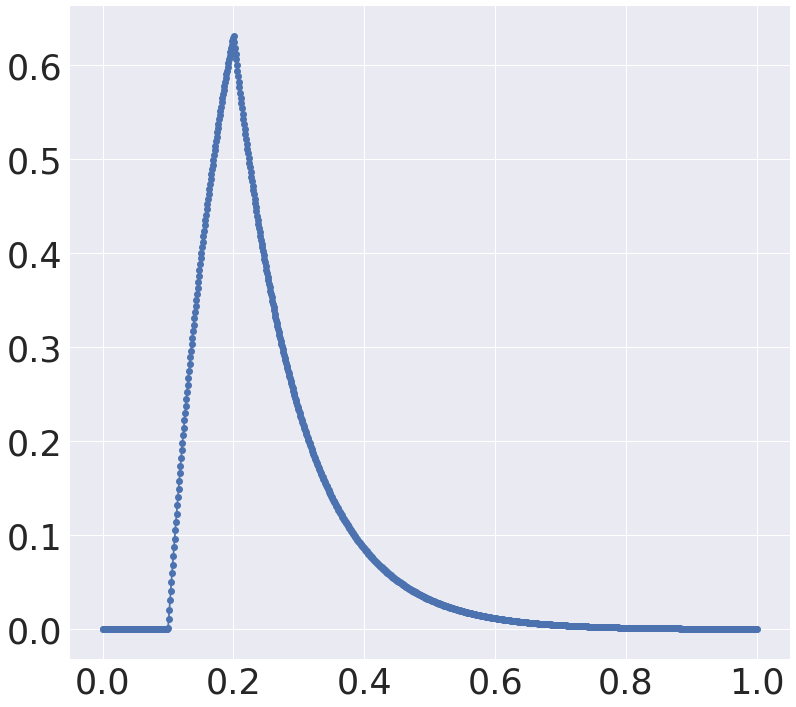

In [7]:
time, s = produce_signal(T_total, T1, T2, dt, tau_z)
plt.plot(time, s, 'o-')

Let's compare this with the signal produced by the filter

In [8]:
tau_m = 0.020
tau_z_pre_ampa = 0.100
tau_z_post_ampa = tau_z_pre_ampa


hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 0.0
epochs = 1

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(network_representation, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)


S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

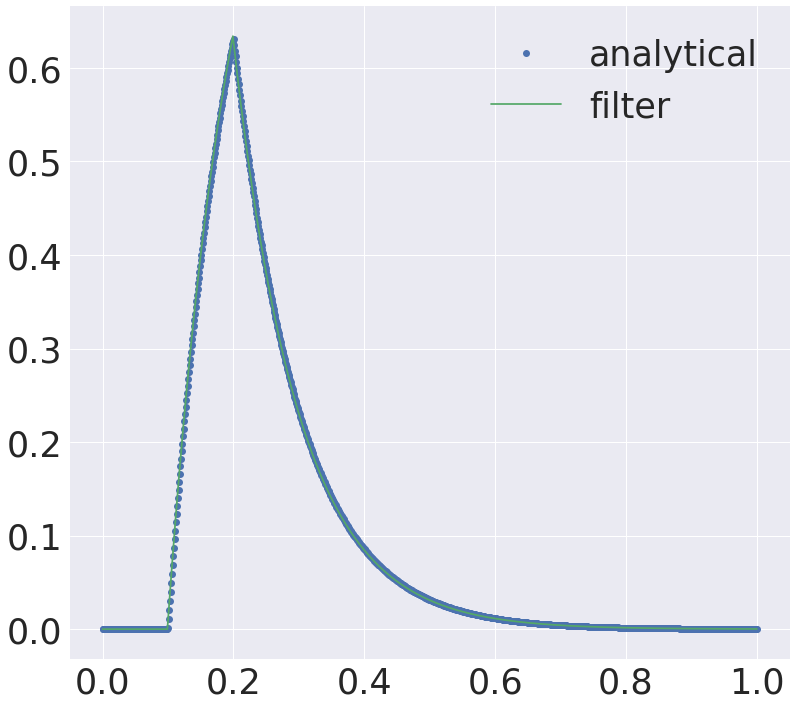

In [9]:
plt.plot(time, s, 'o', label='analytical')
plt.plot(time, z_pre[1, :], '-', label='filter')

plt.legend()

In [10]:
pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)

In [11]:
pi

array([ 0.10009,  0.10008,  0.10004,  0.09995,  0.09969,  0.09897,
        0.097  ,  0.09164,  0.07699,  0.03696])

## Individual probabilities

In [12]:
def probability(tau_z, Tp, Tstart, Ttotal):

    p = Tp - tau_z * np.exp((Tstart - Ttotal)/tau_z) * (np.exp(Tp / tau_z) - 1)

    return p /Ttotal

In [13]:
epsilon = 10e-10

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.300
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 1.0
epochs = 1

num = 20
tau_z_vector = np.linspace(0.020, 0.500, num=num)
p_filter = np.zeros(num)
p_formula = np.zeros(num)


for index, tau_z_pre_ampa in enumerate(tau_z_vector):
    tau_z_post_ampa = tau_z_pre_ampa

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time,
                             inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval,
                             epochs=epochs, resting_time=resting_time)


    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    p_filter[index] = pi[-1]
    Tstart = (n_patterns - 1) * training_time
    Ttotal = timed_input.T_total 
    Tp = training_time
    p_formula[index] = probability(tau_z_pre_ampa, Tp=Tp, Tstart=Tstart, Ttotal=Ttotal)

print('start', Tstart)
print('Total', Ttotal)
print('Tp', Tp)

start 2.6999999999999997
Total 4.0
Tp 0.3


In [14]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln, = ax.plot(tau_z_vector, p_filter, 'o-', label='filtered')
ln, = ax.plot(tau_z_vector, p_formula, 'o-', label='analytical')

ax.set_xlabel(r'$\tau_z_{pre}$')
ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7e233666a8> (for post_execute):


ValueError: 

^
Double subscript (at char 0), (line:1, col:1)

ValueError: 

^
Double subscript (at char 0), (line:1, col:1)

In [4]:
epsilon = 10e-10

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 1.0
epochs = 3

num = 20
inter_sequence_interval_vector = np.linspace(0.0, 3.0, num=num)
p_filter = np.zeros(num)
p_formula = np.zeros(num)


for index, inter_sequence_interval_ in enumerate(inter_sequence_interval_vector):

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time,
                             inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval_,
                             epochs=epochs, resting_time=resting_time)


    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    p_filter[index] = pi[-1]
    Tstart = (n_patterns - 1) * training_time
    Ttotal = timed_input.T_total 
    Tp = training_time
    p_formula[index] = probability(tau_z_pre_ampa, Tp=Tp, Tstart=Tstart, Ttotal=Ttotal)

print('start', Tstart)
print('Total', Ttotal)
print('Tp', Tp)

Traceback (most recent call last):
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/matplotlib/mathtext.py", line 2517, in parse
    result = self._expression.parseString(s)
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 1125, in parseString
    raise exc
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 1115, in parseString
    loc, tokens = self._parse( instring, 0 )
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 1046, in _parseCache
    value = self._parseNoCache( instring, loc, doActions, callPreParse )
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 989, in _parseNoCache
    loc,tokens = self.parseImpl( instring, preloc, doActions )
  File "/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/pyparsing.py", line 2624, in parseImpl
    return self.expr._parse( instring,

NameError: name 'create_orthogonal_canonical_representation' is not defined

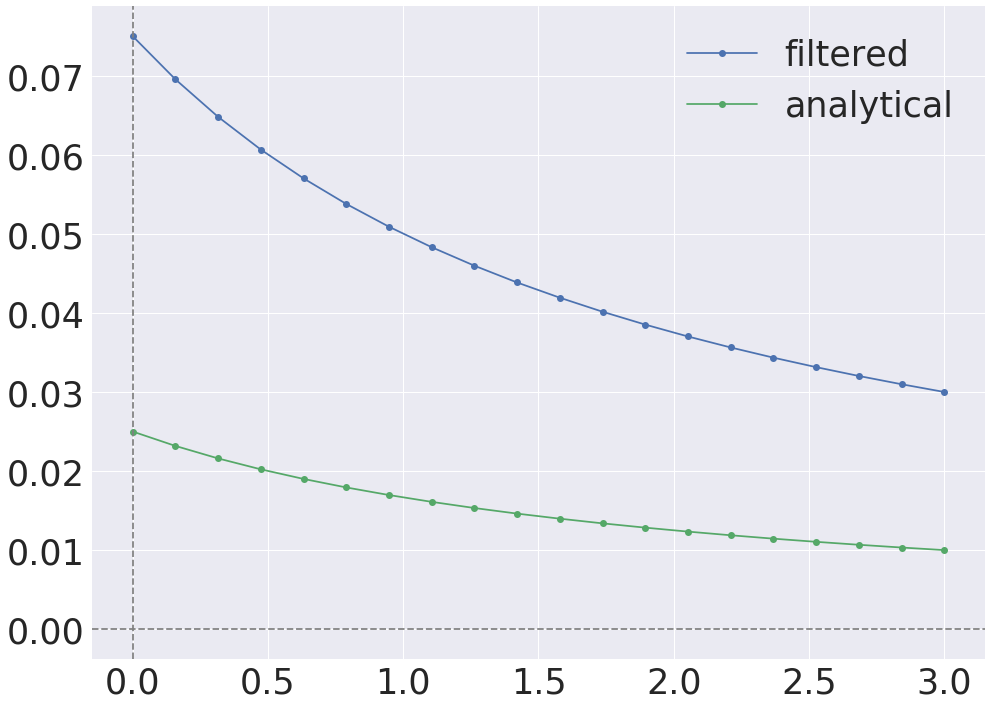

In [16]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln, = ax.plot(inter_sequence_interval_vector, p_filter, 'o-', label='filtered')
ln, = ax.plot(inter_sequence_interval_vector, p_formula, 'o-', label='analytical')

ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend()

## Join Probability

In [98]:
def join_probability(tauz1, tauz2, Tp1, Tp2, Tstart1, Tstart2, Ttotal):

    IPI = Tstart2 - (Tstart1 - Tp1)
    tauz_pro = tauz1 * tauz2
    alpha_z = tauz_pro / (tauz1 + tauz2)

    max1 = 1 - np.exp(-Tp1 / tauz1)
    max2 = 1 - np.exp(-Tp2 / tauz2)

    A1 = max1 * np.exp(-IPI/tauz1) * (tauz1 *(1 - np.exp(-Tp2/tauz1)) + alpha_z * (np.exp(-Tp2/tauz1 - 1)))

    A2_aux1 = tauz1 * (Ttotal - (Tstart1 + Tp1)) + tauz2 * (Ttotal - (Tstart2 + Tp2))
    A2_aux2 = tauz2 * (IPI + Tp2)
    A2 = -alpha_z * max1 * max2 * (np.exp(-A2_aux1/tauz_pro) - np.exp(-A2_aux2 / tauz_pro))

    joint_probability = A1 + A2
    return joint_probability / Ttotal

In [112]:
epsilon = 10e-10

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 3.0
epochs = 1


num = 30
tau_z_vector = np.linspace(0.020, 0.250, num=num)
from_pattern =  8
to_pattern = 8
p_filter = np.zeros(num)
p_formula = np.zeros(num)

for index, tau_z_pre_ampa in enumerate(tau_z_vector):
    tau_z_post_ampa = tau_z_pre_ampa

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time,
                             inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval,
                             epochs=epochs, resting_time=resting_time)


    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    p_filter[index] = P[to_pattern, from_pattern]
    Tstart1 = (from_pattern - 1.0) * training_time
    Tstart2 = (to_pattern - 1.0) * training_time

    Ttotal = timed_input.T_total 
    Tp1 = training_time
    Tp2 = training_time
    p_formula[index] = join_probability(tau_z_pre_ampa, tau_z_post_ampa, Tp1, Tp2, Tstart1, Tstart2, Ttotal)

print('start1', Tstart1)
print('start2', Tstart2)
print('Tp1', Tp1)
print('Tp2', Tp2)
print('Total', Ttotal)


start1 0.7000000000000001
start2 0.7000000000000001
Tp1 0.1
Tp2 0.1
Total 4.0


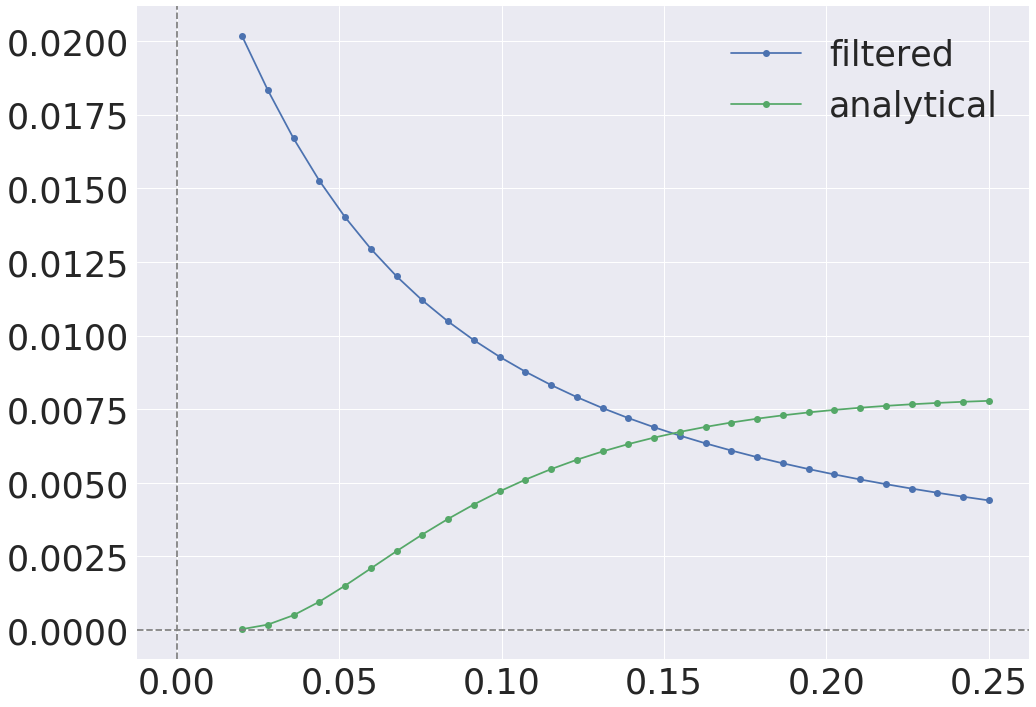

In [113]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ln, = ax.plot(tau_z_vector, p_filter, 'o-', label='filtered')
ln, = ax.plot(tau_z_vector, p_formula, 'o-', label='analytical')

ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend()